In [1]:
# Author: Zacheriah Valis
# Python implementation of a Deep Neural Network in 
# determining financial fraud using highly imbalanced data
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in data
data = pd.read_csv('Desktop/CS599/fraud_data.csv', header = 0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(6362620, 11)
['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [3]:
# Creating hour of day column and adding to data frame
data["HourOfDay"] = np.nan
data.HourOfDay = data.step % 24
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,HourOfDay
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1


In [4]:
# Creating dummy variables and adding to data frame
cat_vars = ['type']
for var in cat_vars:
    cat_list = 'var' + '_' + var
    cat_list = pd.get_dummies(data[var], prefix = var)
    data1 = data.join(cat_list)
    data = data1
cat_vars = ['type']
data_vars = data.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]

print(list(data.columns))

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'HourOfDay', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [5]:
# Deleting nameOrgi and nameDest. These may or may no be useful
# for a neural network, but the data needs to be consistent with
# the logistic regression implementation
data_final = data[to_keep]
data_final = data_final[data_final.columns.difference(['nameOrig', 'nameDest'])]
data_final.columns.values

array(['HourOfDay', 'amount', 'isFlaggedFraud', 'isFraud',
       'newbalanceDest', 'newbalanceOrig', 'oldbalanceDest',
       'oldbalanceOrg', 'step', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'], dtype=object)

In [6]:
# Correcting highly imbalanced data by using synthetic data creation with SMOTE
X = data_final.loc[:, data_final.columns != 'isFraud']
Y = data_final.loc[:, data_final.columns == 'isFraud']

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

os = SMOTE(random_state = 0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
columns = X_train.columns

os_data_X, os_data_Y = os.fit_sample(X_train, Y_train)
os_data_X = pd.DataFrame(data = os_data_X,columns = columns )
os_data_Y = pd.DataFrame(data = os_data_Y,columns = ['isFraud'])

print("Length of oversampled data is ",len(os_data_X))
print("Number of no fraud in oversampled data",len(os_data_Y[os_data_Y['isFraud'] == 0]))
print("Number of fraud",len(os_data_Y[os_data_Y['isFraud'] == 1]))
print("Proportion of no fraud data in oversampled data is ",len(os_data_Y[os_data_Y['isFraud'] == 0]) / len(os_data_X))
print("Proportion of fraud data in oversampled data is ",len(os_data_Y[os_data_Y['isFraud'] == 1]) / len(os_data_X))

Using TensorFlow backend.


Length of oversampled data is  8896080
Number of no fraud in oversampled data 4448040
Number of fraud 4448040
Proportion of no fraud data in oversampled data is  0.5
Proportion of fraud data in oversampled data is  0.5


In [7]:
# Preparing data to fit to model
cols = ['amount', 'newbalanceDest', 'newbalanceOrig', 
        'oldbalanceDest', 'oldbalanceOrg', 'step', 
        'type_CASH_OUT','type_TRANSFER', 'HourOfDay']
X = os_data_X[cols]
#X = X.transpose()
Y = os_data_Y['isFraud']
#Y = Y.transpose()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [8]:
# Function to build model and compile metrics
def build_model(train_data, metrics = ["accuracy"]):
  model = keras.Sequential([
    keras.layers.Dense(
      units = 36,
      activation = 'relu',
      input_shape = (train_data.shape[-1],) # Input layer
    ),
    keras.layers.BatchNormalization(), # Hidden layer #1
    keras.layers.Dropout(0.25), # Hidden layer #2
    keras.layers.Dense(units = 1, activation = 'sigmoid'), # Output layer
  ])

  model.compile(
    optimizer = keras.optimizers.Adam(lr = 0.001),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = metrics
  )

  return model

In [9]:
# Creating class weights
no_fraud_count, fraud_count = np.bincount(data_final.isFraud)
total_count = len(data_final.isFraud)

weight_no_fraud = (1 / no_fraud_count) * (total_count) / 2.0
weight_fraud = (1 / fraud_count) * (total_count) / 2.0

class_weights = {0: weight_no_fraud, 1: weight_fraud}

In [10]:
# List containing relevant metrics
METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'),
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'AUC'),
]

In [11]:
# Build the model and fit with training data
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
BATCH_SIZE = 2048

model = build_model(X_train, metrics = METRICS)
history = model.fit(
    X_train,
    Y_train,
    batch_size = BATCH_SIZE,
    epochs = 100,
    validation_split = 0.05,
    shuffle = True,
    verbose = 0,
    class_weight = class_weights
)

In [ ]:
# Evaluate trained model with test data
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
model.evaluate(X_test, Y_test, batch_size = BATCH_SIZE)

In [13]:
# Function to create confusion matrix with heat map
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p = 0.5):

  tick_labels = ['No Fraud', 'Fraud']

  cm = confusion_matrix(labels, predictions > p)
  ax = sns.heatmap(cm, annot = True, fmt = "d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

In [14]:
Y_pred = model.predict(X_test, batch_size = BATCH_SIZE)

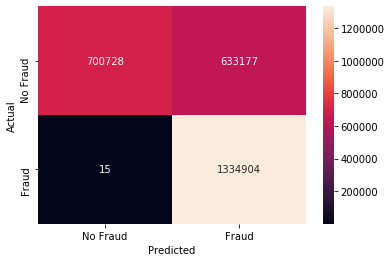

In [15]:
plot_cm(Y_test, Y_pred)

In [16]:
# Function to print metrics and calculate f1 score
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(Y_test, np.round(Y_pred.flatten()))}')
  print()

In [17]:
evaluation_results = model.evaluate(X_test, Y_test, batch_size = BATCH_SIZE, verbose = 0)
print_metrics(model, evaluation_results, Y_pred)

loss :  0.5822347745069347
tp :  1334904.0
fp :  633177.0
tn :  700728.0
fn :  15.0
accuracy :  0.76274496
precision :  0.67827696
recall :  0.99998873
AUC :  0.9866921
f1 score: 0.808297910990009



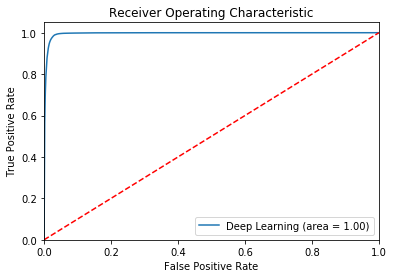

In [18]:
# Plotting ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
logit_roc_auc = roc_auc_score(Y_test, Y_pred)
plt.figure()
plt.plot(fpr, tpr, label = 'Deep Learning (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.savefig('DL_ROC')
plt.show()